In [102]:
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.metrics import precision_score
import pandas as pd
import copy
import datetime as dt
def mycopy(stuff):
  return copy.deepcopy(stuff)

In [460]:
class stockbase:
  def __init__(self,ticker,vol=False):
    self.ticker=ticker
    self.data=None
    self.averagewindow=[2,10,100,1000]
    self.getdata()
    self.vol=vol
    self.dressdata()

  def getdata(self):
    self.data=yf.Ticker(self.ticker).history(period="max")
    self.data=self.data[["Close","Volume"]].copy()
    self.data['Tomorrow']=self.data.shift(-1)['Close']
    self.data['Target']=(self.data['Tomorrow']>self.data['Close']).astype(int)

    self.data=self.data.dropna()

  def dressdata(self):
    #volatility in log
    averagewindow=self.averagewindow
    self.predictors=[]
    for h in averagewindow:
      ravg=self.data.rolling(h).mean()

      ratio=f"CloseRatio_{h}"
      self.data[ratio]=self.data['Close']/ravg['Close']

      trend=f"Trend_{h}"
      self.data[trend]=self.data.shift(1).rolling(h).sum()['Target']

      volatility=f"Volat_{h}"
      self.data[volatility]= np.log((((self.data["Close"]-ravg["Close"])**2).rolling(h).sum()/h)**0.5)

    self.data.replace([np.inf, -np.inf], np.nan, inplace=True)

    self.data=self.data.dropna()

In [461]:
class STOCK(stockbase):
  def __init__(self,ticker):
    super().__init__(ticker)

  def getROI(self,window):
    #Returns ROI (Return on investment) in % of stock in window-size(time) investment over historical data
    data=copy.deepcopy(self.data)
    data['next']=data.shift(-window)['Close']
    data['ROI']=((data["next"]-data['Close'])*100/data['Close'])
    data.dropna(inplace=True)
    ROI=copy.deepcopy(data['ROI'].to_list())
    index=copy.deepcopy(data.index.to_list())
    del data
    return (ROI,index)

  def filter(self,start='2001-01-01',end='2021-01-01'):
    #Returns data filtered by date
    mask=(pd.to_datetime(self.data.index).date > pd.to_datetime(pd.Timestamp(start)).date()) & (pd.to_datetime(self.data.index).date < pd.to_datetime(pd.Timestamp(end)).date())
    temp=mycopy(self.data.loc[self.data.index[mask]])
    return temp

In [462]:
#st=stockbase("GOOG")
#port.stocks[0].data
#st.data

In [463]:
class portfoliobase:
  def __init__(self,tickerlist):
    self.stocklist=copy.deepcopy(tickerlist)
    self.stocks=[STOCK(ticker) for ticker in tickerlist]
    self.weights=None

  def getstatus(self):
    #returns recent (close,volatility[windows],ROI[windows])
    current={}
    for stock in self.stocks:
      close=stock.data['Close'].to_list()[-1]
      window=stock.averagewindow
      volat=[]
      ROI=[]
      for win in window:
        volat.append(mycopy(stock.data[f'Volat_{win}'].to_list()[-1]))
        roi,_=stock.getROI(win)
        ROI.append(roi[-1])
      current[stock.ticker]=mycopy((close,volat,ROI))

    return current

  def printstatus(self):
    currentstatus=self.getstatus()
    window=self.stocks[0].averagewindow
    print(">"*10)
    voltx=''.join([f'Volatility({win}) :::::' for win in window])
    rox=''.join([f'ROI({win}) :::::' for win in window])
    print(f"TICKER ::::: CLOSE :::::"+voltx+rox)
    print(">"*10)
    for stock in self.stocklist:
      voltx=''.join([f'{str(i)} :::::' for i in currentstatus[stock][1]])
      rox=''.join([f'{str(i)} :::::' for i in currentstatus[stock][2]])
      print(f"{stock} ::::: {currentstatus[stock][0]} ::::: "+voltx+rox)

  def plotROI(self,win):
    plt.rcParams.update({'font.size': 7})
    fig, ax = plt.subplots(2, 2)
    c=0
    for stock in self.stocks:
      if c>=4:
        break
      i,j=c//2,c%2
      roi,time=stock.getROI(win)
      ax[i,j].plot(time,roi,label=stock.ticker)
      ax[i,j].legend()
      ax[i,j].grid(which='major')
      ax[i,j].set(ylabel=f'ROI_{win}')
      c=c+1
    return

  def plothist(self,col):
    if "ROI" in col:
      win=int(col.split('_')[1])
      self.plotROI(win)
      return
    plt.rcParams.update({'font.size': 7})
    fig, ax = plt.subplots(2, 2)
    c=0
    for stock in self.stocks:
      if c>=4:
        break
      i,j=c//2,c%2
      ax[i,j].plot(stock.data.index,stock.data[col],label=stock.ticker)
      ax[i,j].legend()
      ax[i,j].grid(which='major')
      ax[i,j].set(ylabel=col)
      c=c+1

  def clean(self,DATA):
    totin=[]
    for stock in self.stocks:
      totin=totin

  def filterport(self,start='2001-01-01',end='2021-01-01'):
    DATA=[]
    for stock in self.stocks:
      da=stock.filter(start,end)
      DATA.append(mycopy(da))
    #DATA=self.clean(DATA)
    return DATA




In [464]:
columns=["Close","Volat_2","Volat_10","Volat_100","Volat_1000","ROI_2","ROI_10","ROI_100","ROI_1000"]
port=portfoliobase(["GOOG","SBUX","BTC-USD","SPELS.BO"])

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


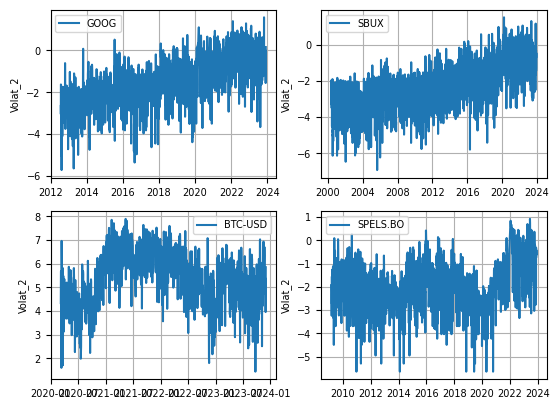

In [465]:

ch=1
port.plothist(columns[ch])
#port.plothist("ROI_2")

In [466]:
#DATA=port.filterport('2021-01-01')
#port.stocks[0].data['Date']=pd.to_datetime(port.stocks[0].data.index).date

In [476]:
class PORTFOLIO(portfoliobase):

  def __init__(self,tickerlist):
    super().__init__(tickerlist)
    self.start=None
    self.end=None

  def getreturnsmatrix(self,start='2015-01-01',end='2021-01-01'):
    #print("r")
    DATA=self.filterport(start,end)
    self.start=mycopy(start)
    self.end=mycopy(end)
    portfolioreturns=[]

    for i in range(len(DATA)):
      close=DATA[i]["Close"].to_list()
      rtn=[np.log(close[i]/close[i-1]) for i in range(1,len(close))]#log return (daily ROI)
      portfolioreturns.append(mycopy(rtn))

    return DATA,portfolioreturns

  def minvariancestrategy(self,covariance):
    #print('m')
    inverse=np.linalg.pinv(covariance)
    ones=np.ones(len(inverse))

    minweights=np.dot(inverse,ones)
    minweights=minweights/np.dot(minweights,ones)

    return minweights

  def eigenstrategy(self,covariance):
    eigval,eigvec=np.linalg.eigh(covariance)

    NUM=4
    eigweights=eigvec[:,-NUM]/np.sum(eigvec[:,-NUM])

    return eigweights

  def getweights(self,choice=0,strategy=None):
    solver=[self.minvariancestrategy,self.eigenstrategy]
    DATA,returns=self.getreturnsmatrix()
    #print(np.vstack(returns).shape)
    if strategy:
      weights=strategy(self.stocklist,DATA,returns)
    else:
      #print('g')

      covariance=np.cov(returns)
      weights=solver[choice](covariance)

    return weights

  def backtest(self,DATA, weights,choice=0,compare=False):
    weights=[max(w,0) for w in weights]#consider long only ==> only buy and hold asset

    returns=[]
    for stock in DATA:
      data=stock["Close"].to_list()
      returns.append([(data[i]-data[i-1])*100/data[i-1] for i in range(1,len(data))])

    returns=np.array([np.array(returns[i])*weights[i] for i in range(len(returns))])
    temp=[]
    for i in range(len(returns[0])):
      tmp=0
      for j in range(len(DATA)):
        tmp=tmp+returns[j][i]
      temp.append(tmp)
    returns=mycopy(temp)
    portreturns=returns#np.dot(returns,weights)
    print
    portcummulative=np.cumsum(portreturns)

    if compare:
      temp=STOCK("QQQ")
      tempdat=temp.filter(start=self.start,end=self.end)["Close"].to_list()
      x=[(tempdat[i]-tempdat[i-1])*100/tempdat[i-1] for i in range(1,len(tempdat))]
      x=np.cumsum(x)
      return (portcummulative,x)

    return (portcummulative,_)







In [477]:
port=PORTFOLIO(["GOOG","SBUX","^DJI","^RUT"])#"BTC-USD"SPELS.BO

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [478]:
DD=[]
x=None
DATA,_=port.getreturnsmatrix()
for choice in range(2):
  w=port.getweights(choice)
  y,x=port.backtest(DATA,w,choice,True)
  DD.append(y)



/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


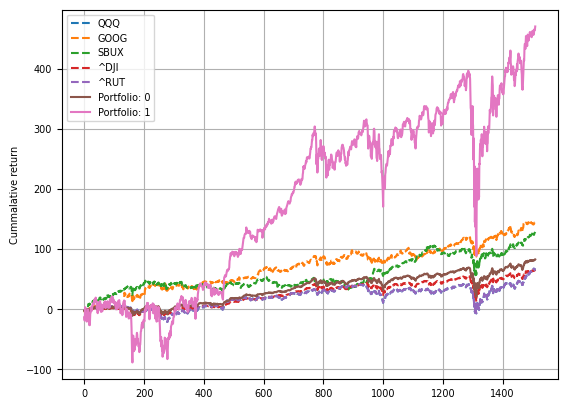

In [484]:
plt.plot(np.arange(len(x)),x,label='QQQ',linestyle='dashed')
for stock in port.stocks:
  tempdat=stock.filter(start=port.start,end=port.end)["Close"].to_list()
  x=[(tempdat[i]-tempdat[i-1])*100/tempdat[i-1] for i in range(1,len(tempdat))]
  x=np.cumsum(x)
  plt.plot(np.arange(len(x)),x,label=stock.ticker,linestyle='dashed')


for choice in range(len(DD)):
  plt.plot(np.arange(len(DD[choice])),DD[choice],label=f'Portfolio: {choice}')

plt.grid(which='major')
plt.legend()
plt.ylabel("Cummalative return")
plt.show()

In [483]:
port.printstatus()

>>>>>>>>>>
TICKER ::::: CLOSE :::::Volatility(2) :::::Volatility(10) :::::Volatility(100) :::::Volatility(1000) :::::ROI(2) :::::ROI(10) :::::ROI(100) :::::ROI(1000) :::::
>>>>>>>>>>
GOOG ::::: 133.9199981689453 ::::: 0.16279520347620388 :::::1.047483635785714 :::::2.365872291924962 :::::3.62343072534626 :::::-3.3905620500627434 :::::-1.80378840430531 :::::13.771131773469657 :::::99.18789101312656 :::::
SBUX ::::: 99.30000305175781 ::::: -0.6756084570263646 :::::0.8774007677663405 :::::1.5989918351609642 :::::3.1034459267291545 :::::-1.8580719981691867 :::::-6.347256252966347 :::::0.2878311493327796 :::::25.156572526663727 :::::
^DJI ::::: 35950.890625 ::::: 5.2153424460655415 :::::6.156729233937168 :::::6.925670328758168 :::::8.514611297723766 :::::1.5074976725390044 :::::2.7426306829281906 :::::4.931111020914102 :::::28.94071713791539 :::::
^RUT ::::: 1809.02001953125 ::::: 1.4593705797575198 :::::3.4353274233692765 :::::4.702008174614969 :::::5.848289980026372 :::::0.90416499281663 